In [2]:
%load_ext autoreload
%autoreload 2

import os
import copy

import numpy as np
import matplotlib.pyplot as plt

from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, hstack
from astropy.convolution import convolve, Box2DKernel

from mrf.display import display_single, SEG_CMAP, draw_circles
from mrf.utils import img_cutout, extract_obj
from mrf.celestial import Celestial, Star
from mrf.utils import psf_bkgsub, save_to_fits

import sep

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Step 1: Download DECaLS images and weights

We download a smaller image (to do fitting) and a larger image (to generate PSF).

In [3]:
if not os.path.isdir('./data'):
    os.mkdirs('./data')

In [4]:
download_dict = {'filt': 'r',
                 'ra': 184.9114,
                 'dec': 29.8832,
                 'small_size': 480,
                 'large_size': 1000,
                 'layer': 'ls-dr9',
                 'output_name': './data/decals'}

In [5]:
from mrf.download import download_decals_cutout
from mrf.download import download_decals_invvar

download_decals_cutout(download_dict['ra'], download_dict['dec'], download_dict['small_size'], 
                       download_dict['filt'], 
                       layer=download_dict['layer'], 
                       pixel_unit=False, output_name=download_dict['output_name'])

download_decals_cutout(download_dict['ra'], download_dict['dec'], download_dict['large_size'], 
                       download_dict['filt'], 
                       layer=download_dict['layer'], 
                       pixel_unit=False, output_name=download_dict['output_name'])

download_decals_invvar(download_dict['ra'], download_dict['dec'], download_dict['small_size'], 
                       download_dict['filt'], 
                       layer=download_dict['layer'], 
                       pixel_unit=False, output_name=download_dict['output_name'])

./data/decals_r.fits: 13.4MB [00:05, 2.65MB/s]                              
./data/decals_r.fits: 0.00B [00:00, ?B/s]

# Downloading ./data/decals_r.fits finished! 


./data/decals_r.fits: 36.0MB [00:04, 7.37MB/s]                              


# Downloading ./data/decals_r.fits finished! 


./data/decals_r_invvar.fits: 11.2MB [00:01, 8.14MB/s]                            

# Downloading ./data/decals_r_invvar.fits finished! 


### Step 2: Derive DECaLS PSF.
Since the small DECaLS cutout doesn't have enough bright stars, we need to work on the larger DECaLS cutout to get a better DECaLS PSF.

If you already have a PSF from somewhere else, jump to the next step

In [6]:
img = fits.open(f'{download_dict["output_name"]}_{download_dict["filt"]}.fits')[0].data
hdr = fits.open(f'{download_dict["output_name"]}_{download_dict["filt"]}.fits')[0].header

In [7]:
# SLOW!
objects, segmap = extract_obj(
    img,
    b=32,
    f=3,
    sigma=2.5,
    minarea=3,
    deblend_nthresh=32,
    deblend_cont=0.003,
    sky_subtract=True,
    show_fig=False,
    flux_aper=[15, 20],
)
objects.sort(keys='flux', reverse=True)
dist = np.sqrt((objects['x'] - img.shape[1] // 2)**2 + (objects['y'] - img.shape[0] // 2)**2) * 0.262
objects = objects[dist > 10]

# Detect 6942 objects


In [8]:
psf_cat = objects
mag = 22.5 - 2.5 * np.log10(psf_cat['flux'])
try:
    psf_cat.add_column(Column(data=mag, name='mag'))
except:
    pass
psf_cat = psf_cat[psf_cat['b'] / psf_cat['a'] > 0.85]
psf_cat = psf_cat[psf_cat['mag'] < 20.5]
print(len(psf_cat))

108


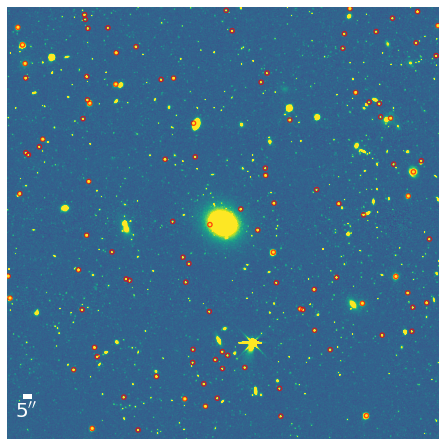

In [9]:
draw_circles(img, psf_cat)

In [10]:
config = {'psfsize': 24, 'padsize': 10, 'cval': 0, 'mask_contam': True, 'norm': 'flux', 'edgesize': 3}

In [11]:
# Construct and stack `Stars`.
size = 2 * config['psfsize'] + 1
stack_set = np.zeros((len(psf_cat), size, size))
bad_indices = []
for i, obj in enumerate(psf_cat):
    try:
        sstar = Star(img, header=hdr, starobj=obj, 
                     halosize=config['psfsize'], 
                     padsize=config['padsize'])
        cval = config['cval']
        if isinstance(cval, str) and 'nan' in cval.lower():
            cval = np.nan
        else:
            cval = float(cval)

        sstar.centralize(method='spline')

        if config['mask_contam'] is True:
            sstar.mask_out_contam(sigma=4.0, deblend_cont=0.0001, show_fig=False, verbose=False)
        if config['norm'] == 'flux_ann':
            stack_set[i, :, :] = sstar.get_masked_image(cval=cval) / sstar.fluxann
        else:
            stack_set[i, :, :] = sstar.get_masked_image(cval=cval) / sstar.flux

    except Exception as e:
        stack_set[i, :, :] = np.ones((size, size)) * 1e9
        bad_indices.append(i)
        print(e)
        
stack_set = np.delete(stack_set, bad_indices, axis=0)
median_psf = np.nanmedian(stack_set, axis=0)
median_psf = psf_bkgsub(median_psf, int(config['edgesize']))
median_psf = convolve(median_psf, Box2DKernel(2))
median_psf /= median_psf.sum()

# Shift distance is beyond the image size.
could not broadcast input array from shape (49,43) into shape (49,49)
could not broadcast input array from shape (47,49) into shape (49,49)


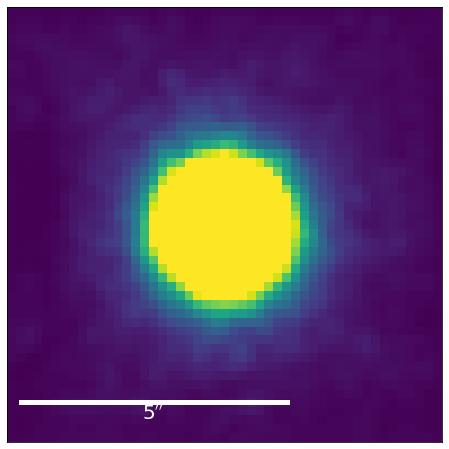

In [12]:
display_single(median_psf);

In [13]:
from astropy.modeling import models, fitting

# Generate fake data
np.random.seed(0)
y, x = np.mgrid[:median_psf.shape[1], :median_psf.shape[0]]

# Fit the data using astropy.modeling
p_init = models.Moffat2D(x_0=config['psfsize'], y_0=config['psfsize'])
fit_p = fitting.LevMarLSQFitter()
p = fit_p(p_init, x, y, median_psf)
print("FWHM of PSF [arcsec]:", p.fwhm * 0.262)

FWHM of PSF [arcsec]: 1.156688042561542


In [37]:
# save your PSF if you're happy with it
save_to_fits(median_psf, f'{download_dict["output_name"]}_{download_dict["filt"]}_psf.fits')

### Step 3: Crop images and invvar map

In [38]:
from mrf.utils import img_cutout

In [39]:
# Crop image
hdu = fits.open(f'{download_dict["output_name"]}_{download_dict["filt"]}.fits')
img = hdu[0].data
hdr = hdu[0].header
w = wcs.WCS(hdr)
img_cutout(img, w, download_dict["ra"], download_dict["dec"], size=(240, 240), 
           pixel_scale=0.262, prefix=f'./{download_dict["output_name"]}_{download_dict["filt"]}_crop', 
           out_dir='./');

In [40]:
# Crop invvar map
hdu = fits.open(f'{download_dict["output_name"]}_{download_dict["filt"]}_invvar.fits')
img = hdu[1].data
hdr = hdu[1].header
w = wcs.WCS(hdr)
img_cutout(img, w, download_dict["ra"], download_dict["dec"], size=(240, 240), 
           pixel_scale=0.262, prefix=f'{download_dict["output_name"]}_{download_dict["filt"]}_invvar_crop', 
           out_dir='./');

### Step 4: Run `pymfit`

[`pymfit`](https://github.com/johnnygreco/pymfit) is a awesome wrapper of [`imfit`](https://www.mpe.mpg.de/~erwin/code/imfit/)

In [45]:
import pymfit # also make sure you have installed the original `imfit`

# files
img_fn = f'{download_dict["output_name"]}_{download_dict["filt"]}_crop.fits'
mask_fn = f'{download_dict["output_name"]}_{download_dict["filt"]}_mask.fits'
var_fn = f'{download_dict["output_name"]}_{download_dict["filt"]}_invvar_crop.fits'
psf_fn = f'{download_dict["output_name"]}_{download_dict["filt"]}_psf.fits'

In [46]:
mask_kws = dict(out_fn=mask_fn, thresh=1.2, kern_sig=2.0, backsize=10, 
                obj_rmin=5, grow_sig=5.0, use_hsc_mask=False)
final_mask = pymfit.make_mask(img_fn, **mask_kws)
 
### add the following to mask out NSC ###

# mask_kws = dict(out_fn=mask_fn, thresh=20, kern_sig=2.0, backsize=8, 
#                 obj_rmin=0, grow_sig=0.0, use_hsc_mask=False)
# final_mask1 = pymfit.make_mask(img_fn, **mask_kws)

# final_mask = (final_mask + final_mask1).astype(bool).astype(int)
# fits.writeto(mask_fn, final_mask, overwrite=True)

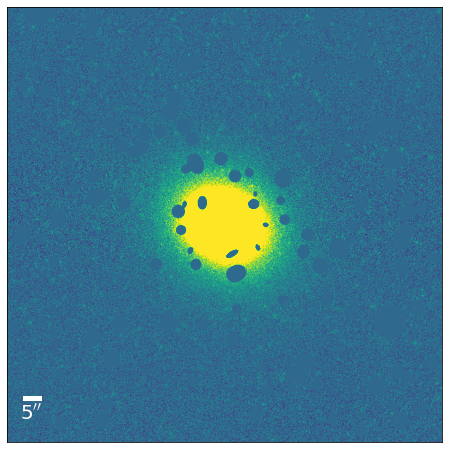

In [47]:
img = fits.open(img_fn)[0].data
display_single(img * (~final_mask.astype(bool)));

imfit './data/decals_r_crop.fits[0]' -c ./config.txt --mask './data/decals_r_mask.fits' --noise './data/decals_r_invvar_crop.fits' --errors-are-weights --psf './data/decals_r_psf.fits'  --save-model ./data/decals_r_crop_model.fits --save-residual ./data/decals_r_crop_res.fits --save-params ./best-fit.txt

Component  1
---------------------
Function   Sersic
X0         459.0407
Y0         458.4292
PA         73.5945
ell        0.1747
n          1.4454
I_e        0.0626
r_e        65.1801

Component  2
---------------------
Function   FlatSky
X0         458.4292
Y0         458.0
I_sky      -0.0002


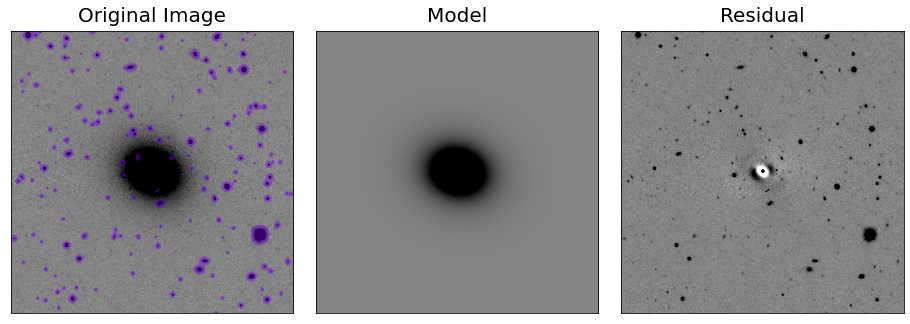

In [48]:
X0, Y0 = pymfit.get_img_center(img_fn, ext=0)
# Initial guesses and constraints
init_params = dict(PA=[20, 0, 360], 
                   n=[1.0, 0.01, 5], 
                   ell=[0.1, 0.1, 0.3]) 

model = pymfit.Model(
    funcs = ['Sersic', 'FlatSky'],    # use lists for multiple components
    params = [init_params, None],        
    centers = [[X0, Y0], [X0, Y0]],
    dcent = 5
)

fitter = pymfit.PymFitter(model)

fitter.run(img_fn+'[0]', mask_fn=mask_fn, var_fn=var_fn, psf_fn=psf_fn, 
           weights=True, will_viz=True)

fitter.print_results()

fitter.viz_results();

In [49]:
print(f"Sersic index: {fitter.results['comp_1']['n']:.3f}", 
      f"+- {fitter.results['comp_1']['n_err']:.3f}")

print(f"Effective radius (along sma): {fitter.results['comp_1']['r_e'] * 0.262:.3f}", 
      f"+- {fitter.results['comp_1']['r_e_err'] * 0.262:.3f}")

Sersic index: 1.445 +- 0.002
Effective radius (along sma): 17.077 +- 0.025
